<!-- @format -->

# Neural Network classification with Pytorch


In [80]:
import sklearn
from sklearn.datasets import make_circles

In [81]:
n_samples = 1000
x, y = make_circles(n_samples=n_samples, noise=0.05)
x[:5], y[:5]

(array([[-0.19363852,  0.94593027],
        [ 1.10854769, -0.02251261],
        [-0.81039629,  0.1812866 ],
        [-0.47360726,  0.63772934],
        [ 0.28896139, -0.75886786]]),
 array([0, 0, 1, 1, 1], dtype=int64))

In [82]:
import pandas as pd

circles = pd.DataFrame({"X0": x[:, 0], "X1": x[:, 1], "label": y})
circles.head(10)

,X0,X1,label
0,-0.193639,0.945930,0
1,1.108548,-0.022513,0
2,-0.810396,0.181287,1
3,-0.473607,0.637729,1
4,0.288961,-0.758868,1
5,-0.525215,-0.666150,1
6,0.114903,1.042967,0
7,0.708686,-0.761729,0
8,-0.523951,-0.641169,1
9,-0.634704,0.493103,1


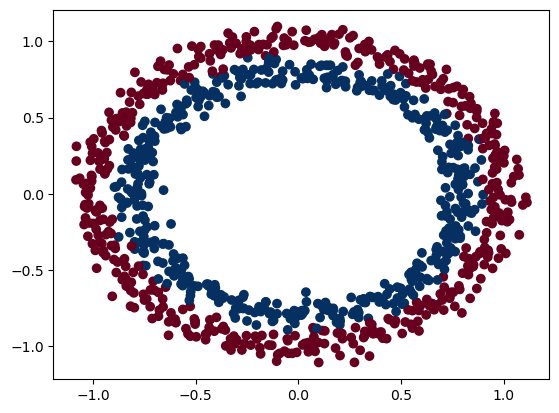

In [83]:
import matplotlib.pyplot as plt

plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdBu)

In [84]:
x.shape, y.shape

((1000, 2), (1000,))

In [85]:
import torch
x = torch.from_numpy(x).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [86]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

<!-- @format -->

## 2. Building a model


In [87]:
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [88]:
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
x_train, y_train, x_test, y_test

(tensor([[-0.7868, -0.1644],
         [ 0.7892, -0.2773],
         [ 0.9589,  0.3190],
         ...,
         [-0.1233,  1.0310],
         [-0.9491, -0.3731],
         [-0.2460,  0.8920]], device='cuda:0'),
 tensor([1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
         0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
         0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
         1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
         1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
         0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
         1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
         1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,

In [89]:
class circle_model_v0(nn.Module):
    def __init__(self, input_features=2, hidden_dim=4, output_features=1):
        super(circle_model_v0, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [90]:
model_0 = circle_model_v0().to(device)
model_0

circle_model_v0(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [91]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [92]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4924, -0.6359],
                      [-0.3886,  0.6794],
                      [-0.4488,  0.1740],
                      [ 0.2028,  0.1696],
                      [-0.4267, -0.6074]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.5637,  0.1071, -0.4065,  0.5820,  0.0657], device='cuda:0')),
             ('1.weight',
              tensor([[0.1902, 0.1930, 0.0071, 0.0413, 0.3459]], device='cuda:0')),
             ('1.bias', tensor([-0.1785], device='cuda:0'))])

In [93]:
untrained_predict = model_0(x_train)
torch.round(untrained_predict[:5]), y_train[:5]

(tensor([[0.],
         [-0.],
         [-0.],
         [-0.],
         [-0.]], device='cuda:0', grad_fn=<RoundBackward0>),
 tensor([1., 1., 0., 0., 1.], device='cuda:0'))

In [94]:
# Set up loss function
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)


def calculate_accuracy(y_true, y_pred):
    correct = torch.eq(y_pred.round(), y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy * 100

In [95]:
# Build a training loop
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(x_test.to(device))
y_logits

tensor([[ 0.3282],
        [ 0.2440],
        [ 0.1130],
        [-0.3929],
        [-0.3328],
        [-0.0733],
        [ 0.2841],
        [ 0.0321],
        [-0.1891],
        [-0.3908],
        [-0.3704],
        [-0.1923],
        [ 0.0353],
        [-0.2833],
        [ 0.1943],
        [-0.2803],
        [ 0.2495],
        [-0.2669],
        [ 0.0882],
        [ 0.2023],
        [-0.2809],
        [-0.2129],
        [-0.0690],
        [-0.1613],
        [ 0.2724],
        [ 0.1427],
        [-0.2978],
        [-0.3431],
        [-0.0259],
        [-0.0235],
        [ 0.1082],
        [ 0.2903],
        [-0.0861],
        [ 0.1108],
        [-0.3969],
        [ 0.1633],
        [ 0.2818],
        [ 0.2777],
        [-0.3573],
        [-0.2410],
        [-0.1156],
        [-0.1976],
        [-0.2928],
        [ 0.2854],
        [ 0.0949],
        [-0.0496],
        [ 0.1997],
        [ 0.1444],
        [ 0.1759],
        [-0.1345],
        [ 0.1680],
        [ 0.3363],
        [-0.

In [96]:
y_test

tensor([0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
        1., 1.], device='cuda:0')

In [97]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5813],
        [0.5607],
        [0.5282],
        [0.4030],
        [0.4176],
        [0.4817],
        [0.5706],
        [0.5080],
        [0.4529],
        [0.4035],
        [0.4084],
        [0.4521],
        [0.5088],
        [0.4297],
        [0.5484],
        [0.4304],
        [0.5621],
        [0.4337],
        [0.5220],
        [0.5504],
        [0.4302],
        [0.4470],
        [0.4828],
        [0.4598],
        [0.5677],
        [0.5356],
        [0.4261],
        [0.4151],
        [0.4935],
        [0.4941],
        [0.5270],
        [0.5721],
        [0.4785],
        [0.5277],
        [0.4021],
        [0.5407],
        [0.5700],
        [0.5690],
        [0.4116],
        [0.4400],
        [0.4711],
        [0.4508],
        [0.4273],
        [0.5709],
        [0.5237],
        [0.4876],
        [0.5498],
        [0.5360],
        [0.5439],
        [0.4664],
        [0.5419],
        [0.5833],
        [0.4316],
        [0.5845],
        [0.4479],
        [0

In [98]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(x_test.to(device))))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_pred_labels.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
        0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
        0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
        0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.,
        0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [99]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 2000

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)
for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = calculate_accuracy(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.inference_mode():
        test_logits = model_0(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = calculate_accuracy(y_test, test_pred)
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%"
        )

Epoch: 0 | Train Loss: 0.69720 | Train Acc: 51.50% | Test Loss: 0.71232 | Test Acc: 45.50%
Epoch: 10 | Train Loss: 0.69590 | Train Acc: 50.62% | Test Loss: 0.71137 | Test Acc: 44.50%
Epoch: 20 | Train Loss: 0.69506 | Train Acc: 51.25% | Test Loss: 0.71038 | Test Acc: 43.50%
Epoch: 30 | Train Loss: 0.69447 | Train Acc: 50.88% | Test Loss: 0.70939 | Test Acc: 42.50%
Epoch: 40 | Train Loss: 0.69402 | Train Acc: 50.62% | Test Loss: 0.70847 | Test Acc: 43.00%
Epoch: 50 | Train Loss: 0.69367 | Train Acc: 51.00% | Test Loss: 0.70764 | Test Acc: 43.50%
Epoch: 60 | Train Loss: 0.69340 | Train Acc: 50.62% | Test Loss: 0.70691 | Test Acc: 43.50%
Epoch: 70 | Train Loss: 0.69317 | Train Acc: 50.50% | Test Loss: 0.70627 | Test Acc: 43.50%
Epoch: 80 | Train Loss: 0.69299 | Train Acc: 50.50% | Test Loss: 0.70573 | Test Acc: 43.50%
Epoch: 90 | Train Loss: 0.69284 | Train Acc: 50.12% | Test Loss: 0.70526 | Test Acc: 43.50%


Epoch: 100 | Train Loss: 0.69272 | Train Acc: 50.12% | Test Loss: 0.70486 | Test Acc: 44.00%
Epoch: 110 | Train Loss: 0.69261 | Train Acc: 50.12% | Test Loss: 0.70452 | Test Acc: 44.00%
Epoch: 120 | Train Loss: 0.69253 | Train Acc: 50.50% | Test Loss: 0.70423 | Test Acc: 42.50%
Epoch: 130 | Train Loss: 0.69246 | Train Acc: 50.12% | Test Loss: 0.70399 | Test Acc: 41.50%
Epoch: 140 | Train Loss: 0.69239 | Train Acc: 50.00% | Test Loss: 0.70378 | Test Acc: 41.50%
Epoch: 150 | Train Loss: 0.69234 | Train Acc: 49.88% | Test Loss: 0.70361 | Test Acc: 41.50%
Epoch: 160 | Train Loss: 0.69230 | Train Acc: 49.38% | Test Loss: 0.70347 | Test Acc: 42.00%
Epoch: 170 | Train Loss: 0.69226 | Train Acc: 50.00% | Test Loss: 0.70334 | Test Acc: 42.00%
Epoch: 180 | Train Loss: 0.69223 | Train Acc: 50.38% | Test Loss: 0.70324 | Test Acc: 41.50%
Epoch: 190 | Train Loss: 0.69220 | Train Acc: 49.88% | Test Loss: 0.70316 | Test Acc: 40.50%
Epoch: 200 | Train Loss: 0.69218 | Train Acc: 49.25% | Test Loss: 0.7

<!-- @format -->

### The model isn't learning anything, so we evaluate it


In [100]:
import requests
from pathlib import Path
# Download helper function
if Path("helper_function.py").is_file() is False:
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "w") as f:
    f.write(request.content.decode("utf-8"))

from helper_functions import plot_decision_boundary, plot_predictions

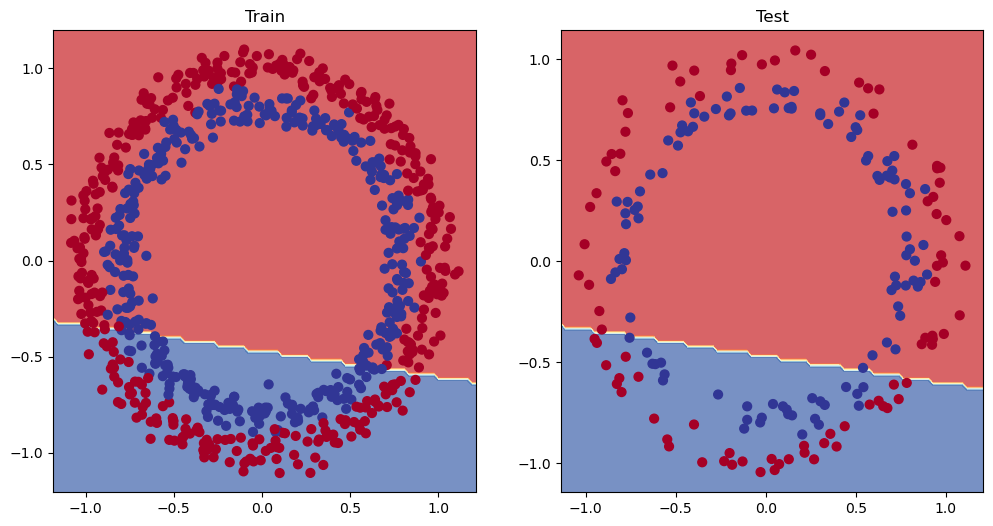

In [101]:
import matplotlib.pyplot as plt

# Plot the decision boundary for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)


<!-- @format -->

## 5. Improving model


In [102]:
# Set up new model
model1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=1),
).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1


Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=1, bias=True)
)

In [103]:
# Train model
epochs = 1000
for epoch in range(epochs):
    model1.train()
    y_logits = model1(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = calculate_accuracy(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.inference_mode():
        test_logits = model1(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = calculate_accuracy(y_test, test_pred)
    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%"
        )


Epoch: 0 | Train Loss: 0.69190 | Train Acc: 56.50% | Test Loss: 0.69225 | Test Acc: 44.50%
Epoch: 100 | Train Loss: 0.03537 | Train Acc: 98.75% | Test Loss: 0.05462 | Test Acc: 98.50%
Epoch: 200 | Train Loss: 0.02861 | Train Acc: 99.00% | Test Loss: 0.05422 | Test Acc: 99.00%
Epoch: 300 | Train Loss: 0.02676 | Train Acc: 99.12% | Test Loss: 0.05808 | Test Acc: 99.00%
Epoch: 400 | Train Loss: 0.02604 | Train Acc: 99.12% | Test Loss: 0.06065 | Test Acc: 99.00%
Epoch: 500 | Train Loss: 0.02463 | Train Acc: 99.12% | Test Loss: 0.06637 | Test Acc: 99.00%
Epoch: 600 | Train Loss: 0.02365 | Train Acc: 99.12% | Test Loss: 0.06949 | Test Acc: 99.00%
Epoch: 700 | Train Loss: 0.02270 | Train Acc: 99.12% | Test Loss: 0.07456 | Test Acc: 99.00%
Epoch: 800 | Train Loss: 0.02093 | Train Acc: 99.12% | Test Loss: 0.07696 | Test Acc: 99.50%
Epoch: 900 | Train Loss: 0.01890 | Train Acc: 99.25% | Test Loss: 0.08175 | Test Acc: 99.50%


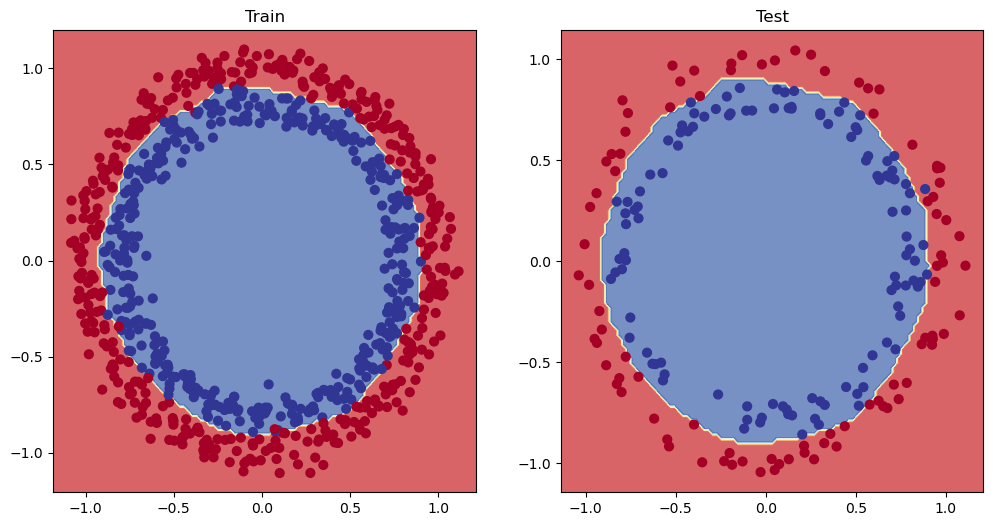

In [104]:
# show decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, x_test, y_test)
